# Probabilistic Roadmap


In this notebook you'll expand on previous random sampling exercises by creating a graph from the points and running A*.

1. Load the obstacle map data
2. Sample nodes (use KDTrees here)
3. Connect nodes (use KDTrees here)
4. Visualize graph
5. Define heuristic
6. Define search method
7. Execute and visualize

We'll load the data for you and provide a template for visualization.

In [1]:
# Again, ugly but we need the latest version of networkx!
# This sometimes fails for unknown reasons, please just 
# "reset and clear output" from the "Kernel" menu above 
# and try again!
import sys
!{sys.executable} -m pip install -I networkx==2.1
import pkg_resources
pkg_resources.require("networkx==2.1")
import networkx as nx

  Using cached networkx-2.1-py2.py3-none-any.whl
  Using cached decorator-5.1.1-py3-none-any.whl (9.1 kB)


ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
jupyter-console 6.5.1 requires ipykernel>=6.14, but you have ipykernel 5.5.5 which is incompatible.
jupyter-console 6.5.1 requires jupyter-core!=5.0.*,>=4.12, but you have jupyter-core 4.8.1 which is incompatible.
jupyter-console 6.5.1 requires traitlets>=5.4, but you have traitlets 4.3.3 which is incompatible.


In [22]:
nx.__version__ # should be 2.1

'2.1'

In [88]:
import numpy as np
import matplotlib.pyplot as plt
from shapely.geometry import Polygon, Point, LineString
from queue import PriorityQueue
import numpy.linalg as LA
%matplotlib inline

In [118]:
plt.rcParams['figure.figsize'] = 14, 14

## Step 1 - Load Data

In [119]:
# This is the same obstacle data from the previous lesson.
filename = 'colliders2.csv'
data = np.loadtxt(filename, delimiter=',', dtype='Float64', skiprows=2)
print(data)

[[-310.2389   -439.2315     85.5         5.          5.         85.5     ]
 [-300.2389   -439.2315     85.5         5.          5.         85.5     ]
 [-290.2389   -439.2315     85.5         5.          5.         85.5     ]
 ...
 [ 257.8061    425.1645      1.75852     1.292725    1.292725    1.944791]
 [ 293.9967    368.3391      3.557666    1.129456    1.129456    3.667319]
 [ 281.5162    354.4156      4.999351    1.053772    1.053772    4.950246]]


#### Create Polygons

In [120]:
def extract_polygons(data):

    polygons = []
    for i in range(data.shape[0]):
        north, east, alt, d_north, d_east, d_alt = data[i, :]
        
        
        
        # TODO: Extract the 4 corners of the obstacle
        # 
        # NOTE: The order of the points matters since
        # `shapely` draws the sequentially from point to point.
        #
        # If the area of the polygon is 0 you've likely got a weird
        # order.
        corners = [(north + d_north , east - d_east), 
                   (north + d_north , east + d_east),
                   (north - d_north , east + d_east),
                   (north - d_north , east - d_east)]
        
        # TODO: Compute the height of the polygon
        height = alt + d_alt

        # TODO: Once you've defined corners, define polygons
        p = Polygon(corners)
        polygons.append((p, height))

    return polygons

In [121]:
polygons = extract_polygons(data)

## Step 2 - Sample Points


You may want to limit the z-axis values.

In [122]:
xmin = np.min(data[:, 0] - data[:, 3])
xmax = np.max(data[:, 0] + data[:, 3])

ymin = np.min(data[:, 1] - data[:, 4])
ymax = np.max(data[:, 1] + data[:, 4])

zmin = 0
# Limit the z axis for the visualization
zmax = 10

max_poly_xy = 2 * np.max((data[:, 3], data[:, 4]))

print("X")
print("min = {0}, max = {1}\n".format(xmin, xmax))

print("Y")
print("min = {0}, max = {1}\n".format(ymin, ymax))

print("Z")
print("min = {0}, max = {1}".format(zmin, zmax))

X
min = -315.2389, max = 604.7611

Y
min = -444.2315, max = 475.7685

Z
min = 0, max = 10


In [124]:
# TODO: sample points randomly
# then use KDTree to find nearest neighbor polygon
# and test for collision

In [125]:
num_samples = 300

xvals = np.random.uniform(xmin, xmax, num_samples)
yvals = np.random.uniform(ymin, ymax, num_samples)
zvals = np.random.uniform(zmin, zmax, num_samples)

points = list(zip(xvals, yvals, zvals))

In [126]:
from sklearn.neighbors import KDTree
centers = np.array([(p[0].centroid.x ,p[0].centroid.y )for p in polygons])
tree = KDTree(centers) 

In [127]:
def collides(polygons, tree, point):   
    # TODO: Determine whether the point collides
    # with any obstacles. 
    idxs = list(tree.query_radius(np.array([point[0], point[1]]).reshape(1, -1), r=max_poly_xy)[0])
    if len(idxs) > 0:
        for idx in idxs:
            polygon = polygons[int(idx)]
            if polygon[0].contains(Point(point)) and point[2] <= polygon[1]:
                return True
    return False

In [128]:
to_keep = []
to_remove = []
for point in points:
    if not collides(polygons, tree, point):
        to_keep.append(point)
    else:
        to_remove.append(point)

## All Points Visualization

In [129]:
from grid_v2 import create_grid
grid = create_grid(data, zmax, 1)

(116, 3)


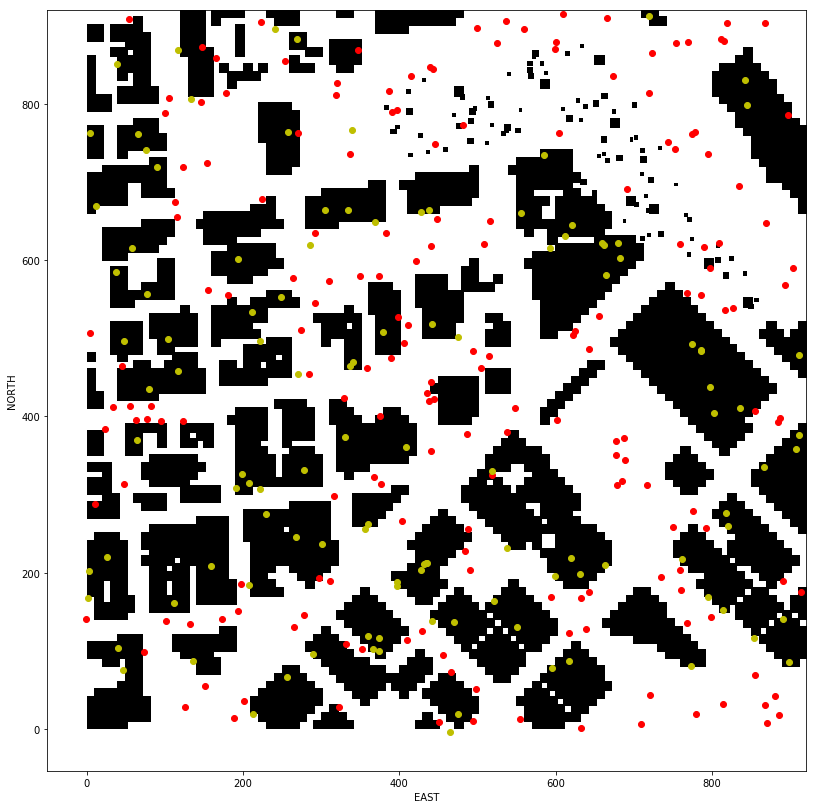

In [130]:
fig = plt.figure()

plt.imshow(grid, cmap='Greys', origin='lower')

nmin = np.min(data[:, 0])
emin = np.min(data[:, 1])

# draw points
all_pts = np.array(to_keep)
north_vals = all_pts[:,0]
east_vals = all_pts[:,1]
plt.scatter(east_vals - emin, north_vals - nmin, c='red')

# draw points
all_pts = np.array(to_remove)
print(all_pts.shape)
north_vals = all_pts[:,0]
east_vals = all_pts[:,1]
plt.scatter(east_vals - emin, north_vals - nmin, c='y')

plt.ylabel('NORTH')
plt.xlabel('EAST')

plt.show()

## Step 3 - Connect Nodes

Now we have to connect the nodes. There are many ways they might be done, it's completely up to you. The only restriction being no edge connecting two nodes may pass through an obstacle.

NOTE: You can use `LineString()` from the `shapely` library to create a line. Additionally, `shapely` geometry objects have a method `.crosses` which return `True` if the geometries cross paths, for instance your `LineString()` with an obstacle `Polygon()`!

In [131]:
# TODO: connect nodes
# Suggested method
    # 1) cast nodes into a graph called "g" using networkx
    # 2) write a method "can_connect()" that:
        # casts two points as a shapely LineString() object
        # tests for collision with a shapely Polygon() object
        # returns True if connection is possible, False otherwise
    # 3) write a method "create_graph()" that:
        # defines a networkx graph as g = Graph()
        # defines a tree = KDTree(nodes)
        # test for connectivity between each node and 
            # k of it's nearest neighbors
        # if nodes are connectable, add an edge to graph
    # Iterate through all candidate nodes!

In [132]:

g.add_nodes_from(to_keep)

In [151]:
g = nx.Graph()
for i, p1 in enumerate(to_keep):
    if i < len(to_keep) -1 :
        w_edges = [((p1),(p2), LA.norm(np.array(p2) - np.array(p1))) for p2 in to_keep[i+1:]]
        g.add_weighted_edges_from(w_edges)
        
        

In [179]:
def can_connect(edge,Polygons):
    l = LineString([n for n in edge])
    for P in Polygons:
        if P[0].crosses(l) and P[1] >= min([n[2] for n in edge]):
            return False
    return True

In [186]:
edges_to_remove = []
for edge in g.edges:
    if not can_connect(edge,polygons):
        edges_to_remove.append(edge)

In [191]:
g.remove_edges_from(edges_to_remove)

## Step 4 - Visualize Graph

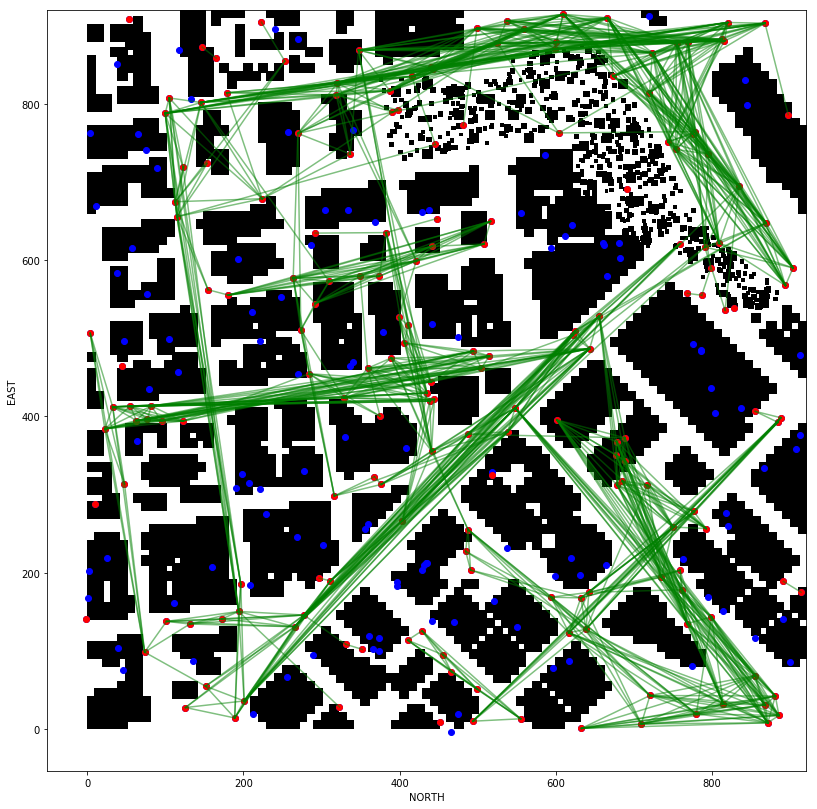

In [198]:
# Create a grid map of the world
from grid_v2 import create_grid
# This will create a grid map at 1 m above ground level
grid = create_grid(data, 1, 1)

fig = plt.figure()

plt.imshow(grid, cmap='Greys', origin='lower')

nmin = np.min(data[:, 0])
emin = np.min(data[:, 1])

# If you have a graph called "g" these plots should work
# Draw edges
for (n1, n2) in g.edges:
    plt.plot([n1[1] - emin, n2[1] - emin], [n1[0] - nmin, n2[0] - nmin], 'green' , alpha=0.5)

# Draw all nodes connected or not in blue
for n1 in points:
    plt.scatter(n1[1] - emin, n1[0] - nmin, c='blue')
    
# Draw connected nodes in red
for n1 in g.nodes:
    plt.scatter(n1[1] - emin, n1[0] - nmin, c='red')
    


plt.xlabel('NORTH')
plt.ylabel('EAST')

plt.show()

## Step 5 - Define Heuristic


In [199]:
def heuristic(position, goal_position , method = 'Euclidean' ):
    # TODO: complete  
    if method == 'Euclidean':
        h = ((position[0]-goal_position[0])**2 + (position[1]-goal_position[1])**2)**0.5
    elif method == 'Manhattan':
        h = abs(position[0]-goal_position[0]) + abs(position[1]-goal_position[1])
    else:
        print('Warning!!! Unknown method - {} \n return h=0 '.format(method))
        h = 0
            
    return h

## Step 6 - Complete A*

In [219]:
def a_star_graph(G, h, start_n, goal_n):
    """Modified A* to work with NetworkX graphs."""
    
    # TODO: complete
    paths = []
    path = []
    path_cost = 0
    queue = PriorityQueue()
    queue.put((0, start_n))
    visited = set(start_n)

    branch = {}
    found = False
    
    while not queue.empty():
        item = queue.get()
        current_node = item[1]
        if current_node == start_n:
            current_cost = 0.0
        else:              
            current_cost = branch[current_node][0]
            
        if current_node == goal_n:        
            print('Found a path.')
            found = True 
            break
        else:
            for next_node in G[current_node]:
                w = G[current_node][next_node]['weight']
                # get the tuple repre.values())[0]['weight']sentation
                branch_cost = current_cost + G[current_node][next_node]['weight']
                queue_cost = branch_cost + h(next_node, goal_n)
                
                if next_node not in visited: 
                    visited.add(next_node)               
                    branch[next_node] = (branch_cost, current_node, next_node)
                    queue.put((queue_cost, next_node))
                else:
                    if branch_cost < branch[next_node][0]:
                        branch[next_node] = (branch_cost, current_node, next_node)
                        queue.put((queue_cost, next_node))
                        
             
    if found:
        # retrace steps
        n = goal_n
        path_cost = branch[n][0]
        path.append(goal_n)
        while branch[n][1] != start_n:
            path.append(branch[n][1])
            n = branch[n][1]
        path.append(branch[n][1])
            
    else:
        print('**********************')
        print('Failed to find a path!')
        print('**********************') 
    return path[::-1], path_cost

## Step 7 - Visualize Path


In [210]:
def find_start_goal_in_graph(G, start, goal):
    # TODO: find start and goal on skeleton
    # Some useful functions might be:
        # np.nonzero()
        # np.transpose()
        # np.linalg.norm()
        # np.argmin()

    idx = np.argmin([((start[0]-x)**2 + (start[1]-y)**2 + (start[2]-z)**2) for x,y,z in G.nodes])
    node_start = list(G.nodes)[idx]
    
    idx = np.argmin([((goal[0]-x)**2 + (goal[1]-y)**2 + (goal[2]-z)**2) for x,y,z in G.nodes])
    node_goal = list(G.nodes)[idx]
    return node_start, node_goal

In [227]:
# Generate random Start & Goal points
xvals = np.random.uniform(xmin, xmax, 2)
yvals = np.random.uniform(ymin, ymax, 2)
zvals = np.random.uniform(zmin, zmax, 2)

end_points = list(zip(xvals, yvals, zvals))
start_ne = end_points[0]
goal_ne  = end_points[1]
g_start, g_goal = find_start_goal_in_graph(g, start_ne ,goal_ne )

In [228]:
path, cost =  a_star_graph(g, heuristic, g_start, g_goal)

Found a path.


Text(0,0.5,'EAST')

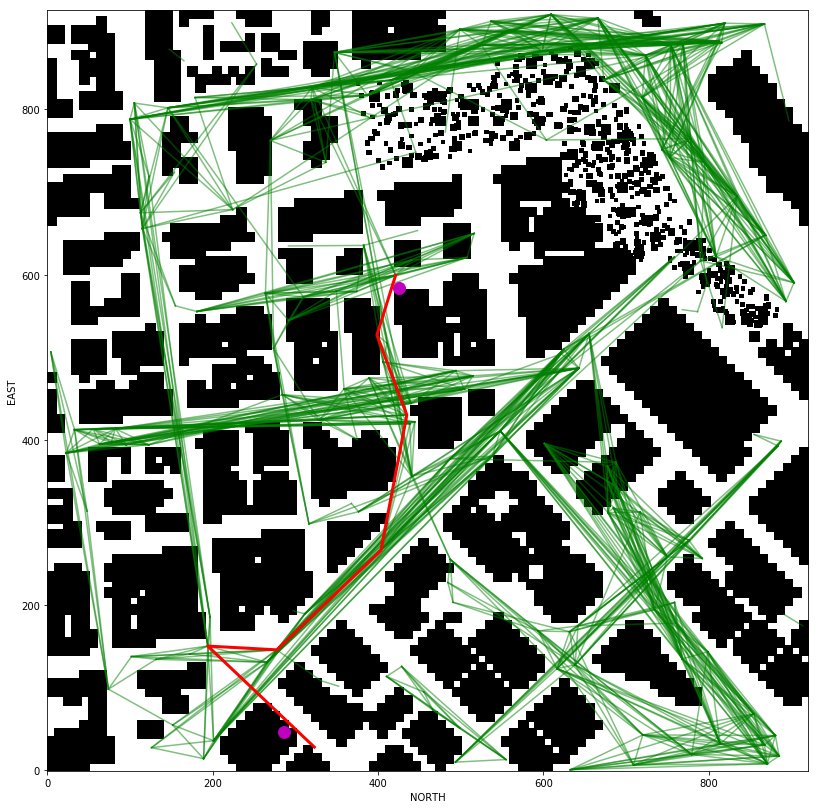

In [238]:
fig = plt.figure()
plt.imshow(grid, cmap='Greys', origin='lower')
# Add code to visualize path here


for (n1, n2) in g.edges:
    plt.plot([n1[1] - emin, n2[1] - emin], [n1[0] - nmin, n2[0] - nmin], 'green' , alpha=0.5)
    
# For the purposes of the visual the east coordinate lay along
# the x-axis and the north coordinates long the y-axis.
plt.plot(start_ne[1]- emin, start_ne[0]- nmin, 'mo', markersize=12)
# Uncomment the following as needed
plt.plot(goal_ne[1]- emin, goal_ne[0]- nmin, 'mo', markersize=12)

pp = np.array(path)
plt.plot(pp[:, 1]- emin, pp[:, 0]- nmin, 'r', linewidth=3)

plt.xlabel('NORTH')
plt.ylabel('EAST')
